In [1]:
# This cell is for HPC usage.
import sys 

RUNNING_ON_HPC = False
TEST_RUN = False
if len(sys.argv)>1 and sys.argv[1] == 'hpc':
    RUNNING_ON_HPC = True
if len(sys.argv)>2 and sys.argv[2] == 'test':
    TEST_RUN = True
    print('TEST MODE!')
print('RUNNING_ON_HPC: {}\n'
      'TEST_RUN: {}'.format(RUNNING_ON_HPC, TEST_RUN))


RUNNING_ON_HPC: False
TEST_RUN: False


In [2]:
import os
import numpy as np
import time
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectKBest, SelectFromModel

from sklearn.metrics import make_scorer

import sklearn.decomposition

import sklearn


In [3]:
ml_dir = '/Users/miroslavkovalenko/Documents/project_supporting_material/UGent' \
                            '/Master_Thesis/fase_2'
if RUNNING_ON_HPC:
    ml_dir = 'fase_2'
ONE_VALUE_DIFFERENCE = 'one_value_difference'
RUNNING_DIFFERENCE = 'running_difference'

post_features_path = ''

fe_mode = RUNNING_DIFFERENCE # INPUT feature extraciton mode used
print('fe_mode is: {}'.format(fe_mode))
if fe_mode == ONE_VALUE_DIFFERENCE:
    post_features_path += ''
elif fe_mode == RUNNING_DIFFERENCE:
    post_features_path += '_running_difference'
else:
    raise Exception('Mode invalid.')

extended_length_semgents = True # INPUT 
print('extended_length_semgents: {}'.format(extended_length_semgents))
if extended_length_semgents is False:
    post_features_path += ''
else:
    post_features_path += '_extended_length_semgents'

features_name = '' # INPUT
features_name = '_balanced_falses' # INPUT
post_features_path += features_name
features_path = os.path.join(ml_dir, 'features{}.pkl'.format(post_features_path)) # INPUT
print('Features path used: {}'.format(features_path))
augm_features_path = os.path.join(ml_dir, 'augm_features{}.pkl'.format(post_features_path)) # INPUT
# augm_features_path = os.path.join(ml_dir, 'augm_features{}.pkl'.format('_running_difference')) # INPUT
print('Augm features path used: {}'.format(augm_features_path))

model_pipe_path = os.path.join(ml_dir, 'model_pipe.pkl') # OUTPUT
grid_search_cv_results_path = os.path.join(ml_dir, 'grid_search_cv_results.pkl') # OUTPUT


fe_mode is: running_difference
extended_length_semgents: True
Features path used: /Users/miroslavkovalenko/Documents/project_supporting_material/UGent/Master_Thesis/fase_2/features_running_difference_extended_length_semgents_balanced_falses.pkl
Augm features path used: /Users/miroslavkovalenko/Documents/project_supporting_material/UGent/Master_Thesis/fase_2/augm_features_running_difference_extended_length_semgents_balanced_falses.pkl


In [4]:
with open(features_path, 'rb') as file:
    X_all, target_all = pickle.load(file, encoding='latin1') # encoding='latin1' beacause pickle is from Python 2
                                                             # see https://stackoverflow.com/questions/28218466/unpickling-a-python-2-object-with-python-3#28218598
    

[904  23]


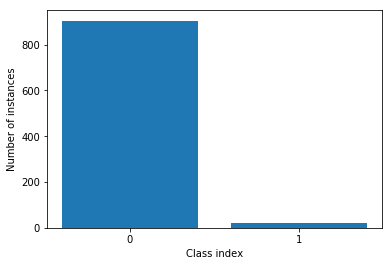

In [5]:
plt_bincount  = np.bincount(target_all)
print(plt_bincount)
plt.bar(['0','1'], plt_bincount)
plt.xlabel("Class index")
plt.ylabel("Number of instances")
plt.show()


In [6]:
print(X_all.shape)
print(target_all.shape)

(927, 408)
(927,)


## Augmented features

In [7]:
with open(augm_features_path, 'rb') as file:
    augm_X_all, augm_target_all = pickle.load(file, encoding='latin1')
    
print(augm_X_all.shape)
print(augm_target_all.shape)


(138, 408)
(138,)


## Data sanitation removal of redudundancies, outliers, invalid values.

In [8]:
# TODO: remove when input is already sanitized

# for sample_idx in range(augm_X_all.shape[0]):
#     sample_X = augm_X_all[sample_idx]
#     sample_sum_onset = sample_X[192:192+(3*32)].reshape((3,32))
#     diff_sum = (sample_sum_onset[0,:] - sample_sum_onset[0,:]).sum()
#     if diff_sum != 0.:
#         print('There is a case where flux != hfc!!!')


In [9]:
# Delete the redundant feature (flux)
# 
# feature_idices_flux = np.arange(192,192+32)
# augm_X_all = np.delete(augm_X_all,feature_idices_flux, axis=1)


## Resulting features


In [10]:
X_all = np.concatenate((X_all, augm_X_all))
target_all = np.concatenate((target_all, augm_target_all))

print(X_all.shape)
print(target_all.shape)


(1065, 408)
(1065,)


# Data analysis

[904 161]


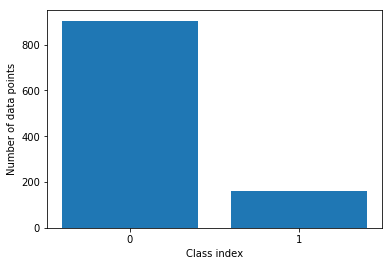

In [11]:

# TODO: visualise class balance + statistics
f = plt.figure()

plt_bincount  = np.bincount(target_all)
print(plt_bincount)
plt.bar(['0','1'], plt_bincount)
plt.xlabel("Class index")
plt.ylabel("Number of data points")
plt.show()

f.savefig("class-histogram-after.pdf", bbox_inches='tight')


In [12]:
# Plot few data points

# --------PARAMETERS---------
sample_target = 1
sample_idx_found = 3
N = 8
N_acc = 4 # acc = accent (')
mfcc_shape = np.array([24,12])
sum_onset_shape = np.array([2,48])
odf_methods = ['flux', 'hfc', 'complex'] # INPUT needed for plots
odf_methods = ['flux/hfc', 'complex'] # INPUT needed for plots (after cleansing)
loudness_shape = np.array([24])

sample_idx = np.where(target_all == sample_target)[0][sample_idx_found]
sample_X = X_all[sample_idx]
sample_target = target_all[sample_idx]
print('Sample: target (verify) {}'.format(sample_target))

sample_mfcc = sample_X[:mfcc_shape.prod()].reshape(tuple(mfcc_shape))
print('Shape mfcc (verify): {}'.format(sample_mfcc.shape))
sample_sum_onset = sample_X[mfcc_shape.prod():mfcc_shape.prod()+sum_onset_shape.prod()].reshape(tuple(sum_onset_shape))
print('Shape sum onset (verify): {}'.format(sample_sum_onset.shape))
sample_loudness = sample_X[mfcc_shape.prod()+sum_onset_shape.prod():]
print('Shape loudness (verify): {}'.format(sample_loudness.shape))


Sample: target (verify) 1
Shape mfcc (verify): (24, 12)
Shape sum onset (verify): (2, 48)
Shape loudness (verify): (24,)


/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/master-thesis-3.6.6/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/master-thesis-3.6.6/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


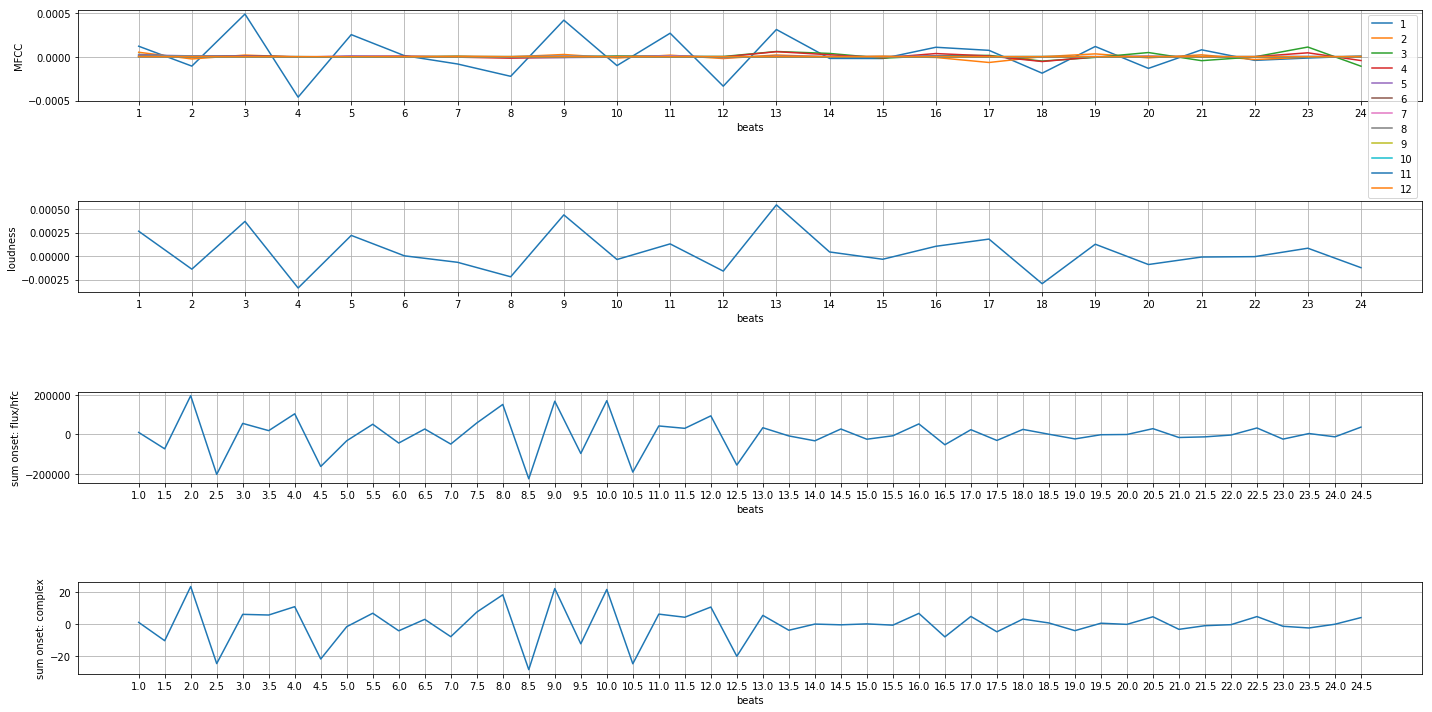

In [13]:
fig, ax = plt.subplots(4, 1, facecolor='white',figsize=(20,10))

for bin_idx in range(12):
    ax[0].plot(np.arange(mfcc_shape[0])+1, sample_mfcc[:,bin_idx], label='{}'.format(bin_idx+1))
ax[0].set(xticks=range(1,mfcc_shape[0]+1),
          xlabel='beats',
          ylabel='MFCC')
ax[0].grid(True)
ax[0].legend()


ax[1].plot(np.arange(loudness_shape[0])+1, sample_loudness, label='loudness')
ax[1].set(xticks=range(1,loudness_shape[0]+1),
          xlabel='beats',
          ylabel='loudness')
ax[1].grid(True)


for odf_method_idx, odf_method in enumerate(odf_methods[:]):
    ax[2+odf_method_idx].plot(np.arange(1,sum_onset_shape[1]/2+1,.5), sample_sum_onset[odf_method_idx,:], label=odf_method)
    ax[2+odf_method_idx].set(xticks=np.arange(1,sum_onset_shape[1]/2+1,.5),
              xlabel='beats',
              ylabel='sum onset: {}'.format(odf_method))
    ax[2+odf_method_idx].grid(True)
    # ax[2+odf_method_idx].legend()

fig.set_tight_layout(True)
fig.show()


In [14]:

#data = np.c_[X, target]
#columns = np.append(range(codebook_size), ["target"])
pd_data = np.c_[X_all]
pd_columns = range(X_all.shape[1])
pd_data = pd.DataFrame(pd_data, columns=pd_columns)

pd_desc = pd_data.describe()
pd_desc

0             1             2             3             4    \
count  1.065000e+03  1.065000e+03  1.065000e+03  1.065000e+03  1.065000e+03   
mean   3.463840e-04  5.098060e-05  2.674833e-05  1.419563e-05  7.786919e-06   
std    2.834228e-04  5.651289e-05  3.063037e-05  1.515160e-05  8.018427e-06   
min    3.303386e-11  2.854626e-11  3.764777e-11  4.096934e-11  1.604717e-11   
25%    1.024312e-04  1.501262e-05  8.293528e-06  4.431181e-06  2.761051e-06   
50%    3.043389e-04  3.490748e-05  1.768462e-05  9.497403e-06  6.015313e-06   
75%    4.933971e-04  6.450729e-05  3.343350e-05  1.845490e-05  9.918255e-06   
max    1.514806e-03  4.254894e-04  2.566095e-04  1.240055e-04  1.008225e-04   

                5             6             7             8             9    \
count  1.065000e+03  1.065000e+03  1.065000e+03  1.065000e+03  1.065000e+03   
mean   4.234115e-06  2.711073e-06  2.023601e-06  1.720845e-06  1.264603e-06   
std    3.379553e-06  2.141068e-06  1.654437e-06  1.579051e-06  1.170200e-06   
min    2.397278e-12  1.352771e-12  1.307950e-12  1.166470e-12  1.561372e-13   
25%    1.953240e-06  1.046332e-06  8.078915e-07  6.064906e-07  3.373543e-07   
50%    3.693158e-06  2.531885e-06  1.787106e-06  1.438815e-06  9.909191e-07   
75%    5.789360e-06  3.786118e-06  2.797937e-06  2.350237e-06  1.786828e-06   
max    4.020321e-05  2.014018e-05  1.748511e-05  8.970903e-06  6.533417e-06   

       ...           398          399          400          401           402  \
count  ...  1.065000e+03  1065.000000  1065.000000  1065.000000  1.065000e+03   
mean   ...  7.219523e-06     0.000001     0.000014    -0.000008  7.526475e-06   
std    ...  1.316725e-04     0.000128     0.000134     0.000130  1.366498e-04   
min    ... -5.318923e-04    -0.000532    -0.000532    -0.000532 -5.318923e-04   
25%    ... -4.374920e-05    -0.000052    -0.000044    -0.000060 -5.185785e-05   
50%    ... -1.720045e-07    -0.000004     0.000005    -0.000006  7.490453e-07   
75%    ...  5.221645e-05     0.000047     0.000070     0.000047  6.164284e-05   
max    ...  5.515831e-04     0.000552     0.000552     0.000552  5.515831e-04   

                403           404          405           406          407  
count  1.065000e+03  1.065000e+03  1065.000000  1.065000e+03  1065.000000  
mean  -2.637897e-07  3.375503e-06    -0.000006 -1.458990e-07     0.000003  
std    1.302033e-04  1.238652e-04     0.000124  1.266433e-04     0.000124  
min   -5.318923e-04 -5.318923e-04    -0.000532 -5.318923e-04    -0.000532  
25%   -5.430443e-05 -5.028944e-05    -0.000062 -5.580371e-05    -0.000051  
50%   -1.732304e-06  2.279121e-07    -0.000006 -1.390261e-06     0.000002  
75%    5.393938e-05  5.478748e-05     0.000046  5.478748e-05     0.000053  
max    5.515831e-04  5.515831e-04     0.000550  5.504609e-04     0.000550  

[8 rows x 408 columns]

In [15]:
pd_desc.T.describe()



count          mean           std            min           25%  \
count   408.0  4.080000e+02  4.080000e+02     408.000000  4.080000e+02   
mean   1065.0  1.073783e+02  6.243344e+03  -24370.349607 -3.250916e+03   
std       0.0  1.081277e+04  1.720174e+04   74225.670836  1.367276e+04   
min    1065.0 -4.044331e+04  8.592611e-08 -361237.183792 -8.286920e+04   
25%    1065.0 -2.335597e-07  1.429459e-06      -0.000978 -5.458541e-05   
50%    1065.0  7.077289e-11  1.275671e-05      -0.000095 -1.301783e-06   
75%    1065.0  5.597155e-07  2.273566e-04      -0.000008 -1.109429e-07   
max    1065.0  5.228077e+04  6.226412e+04       0.041759  1.901728e+04   

                50%           75%           max  
count  4.080000e+02  4.080000e+02  4.080000e+02  
mean   1.585325e+02  3.357812e+03  2.616821e+04  
std    7.288538e+03  1.360916e+04  7.561689e+04  
min   -2.987612e+04 -1.102485e+03  7.962780e-07  
25%   -1.337204e-07  2.578662e-07  1.529827e-05  
50%   -9.932081e-10  2.566906e-06  1.083311e-04  
75%    1.949197e-11  7.054457e-05  9.533997e-04  
max    4.588394e+04  7.580623e+04  3.514124e+05

# Validation set and train set and test set

In [16]:
# TODO: rename variable names accordingly from here

n_splits_test = 3
n_splits_test = 5
n_splits_validation=5

cv_test = StratifiedKFold(n_splits=n_splits_test, shuffle=True)
for val_indices, test_indeces in cv_test.split(X_all, target_all):
    X_val, X_test = X_all[val_indices], X_all[test_indeces]
    target_val, target_test = target_all[val_indices], target_all[test_indeces]
    break
    
print('Validation/training set: {}\n'
      'Test set: {}'.format(X_val.shape[0],X_test.shape[0]))
X = X_val
target = target_val

cv = StratifiedKFold(n_splits=n_splits_validation, shuffle=True)
for train_indeces, val_indeces in cv.split(X, target):
    print('\nFor a split:\n'
          '\tTraining set: {}\n'
          '\tValidation set: {}'.format(X[train_indeces].shape[0],
                                        X[val_indeces].shape[0]))
    break

Validation/training set: 851
Test set: 214

For a split:
	Training set: 680
	Validation set: 171


# Hypertuning (feature selection, dimensionality reduction, scaling, model hypertuning)

In [17]:
# Parameters for a full grid search

grid_search_cv_tuned_parameters_full_scalers = [None, sklearn.preprocessing.StandardScaler(),
                                                sklearn.preprocessing.MinMaxScaler(),
                                                sklearn.preprocessing.MaxAbsScaler(),
                                                sklearn.preprocessing.RobustScaler(), 
                                                sklearn.preprocessing.PowerTransformer(method='yeo-johnson'),
                                                sklearn.preprocessing.QuantileTransformer(output_distribution='normal'),
                                                sklearn.preprocessing.QuantileTransformer(output_distribution='uniform'),
                                                sklearn.preprocessing.Normalizer()]
grid_search_cv_tuned_parameters_full_scalers_non_neg_out = [
    sklearn.preprocessing.MinMaxScaler(),
    sklearn.preprocessing.QuantileTransformer(output_distribution='uniform'),
                                                            ]
grid_search_cv_tuned_parameters_full_classifier__C = 10.**np.arange(start=-2,stop=12)
grid_search_cv_tuned_parameters_full_feature_selection__count = np.arange(10,X.shape[1],20)
grid_search_cv_tuned_parameters_full = [
    {
        'scaler': grid_search_cv_tuned_parameters_full_scalers,
        'feature_selection': [SelectKBest(sklearn.feature_selection.f_classif)],
        'feature_selection__k': grid_search_cv_tuned_parameters_full_feature_selection__count,
        'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    },
    {
        # Only scalers which output is >= 0 (suitible for chi2)
        'scaler': grid_search_cv_tuned_parameters_full_scalers_non_neg_out,
        'feature_selection': [SelectKBest(sklearn.feature_selection.chi2)],
        'feature_selection__k': grid_search_cv_tuned_parameters_full_feature_selection__count,
        'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    },
    {
        # Only scalers which output is >= 0 (suitible for NMF)
        # TODO: NMF does not work (error: non-negative)
        # np.where(sklearn.preprocessing.QuantileTransformer(output_distribution='uniform').fit_transform(X_all) < 0)
        # 'scaler': grid_search_cv_tuned_parameters_full_scalers_non_neg_out,
        # 'feature_selection': [sklearn.decomposition.NMF()],
        # 'feature_selection__n_components': grid_search_cv_tuned_parameters_full_feature_selection__count,
        # 'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    },
    {
        'scaler': grid_search_cv_tuned_parameters_full_scalers,
        'feature_selection': [sklearn.decomposition.PCA()],
        'feature_selection__n_components': grid_search_cv_tuned_parameters_full_feature_selection__count,
        'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    }
]

grid_search_cv_tuned_parameters_2_scalers = [sklearn.preprocessing.MinMaxScaler()]
grid_search_cv_tuned_parameters_2 = [
    {
        'scaler': grid_search_cv_tuned_parameters_2_scalers,
        'feature_selection': [SelectKBest(sklearn.feature_selection.f_classif)],
        'feature_selection__k': grid_search_cv_tuned_parameters_full_feature_selection__count,
        'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    },
    {
        # Only scalers which output is >= 0 (suitible for chi2)
        'scaler': grid_search_cv_tuned_parameters_2_scalers,
        'feature_selection': [SelectKBest(sklearn.feature_selection.chi2)],
        'feature_selection__k': grid_search_cv_tuned_parameters_full_feature_selection__count,
        'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    },
    {
        # Only scalers which output is >= 0 (suitible for NMF)
        # TODO: NMF does not work (error: non-negative)
        # np.where(sklearn.preprocessing.QuantileTransformer(output_distribution='uniform').fit_transform(X_all) < 0)
        # 'scaler': grid_search_cv_tuned_parameters_full_scalers_non_neg_out,
        # 'feature_selection': [sklearn.decomposition.NMF()],
        # 'feature_selection__n_components': grid_search_cv_tuned_parameters_full_feature_selection__count,
        # 'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    },
    {
        'scaler': grid_search_cv_tuned_parameters_2_scalers,
        'feature_selection': [sklearn.decomposition.PCA()],
        'feature_selection__n_components': grid_search_cv_tuned_parameters_full_feature_selection__count,
        'classifier__C': grid_search_cv_tuned_parameters_full_classifier__C,
    }
]

In [12]:
# Hypertuning execution

grid_search_cv_memory = None
if not RUNNING_ON_HPC:
    ## Cashing
    from tempfile import mkdtemp
    from shutil import rmtree
    from joblib import Memory

    # Create a temporary folder to store the transformers of the pipeline
    grid_search_cv_cachedir = mkdtemp()
    grid_search_cv_memory = Memory(location=grid_search_cv_cachedir, verbose=0)

_start_time = time.time()
estimators_model_pipe = [
    ('scaler',None),
    ('feature_selection',SelectKBest(sklearn.feature_selection.f_classif)),
    ('classifier',LogisticRegression(class_weight='balanced',
                                 solver='liblinear'))
]
model_pipe = Pipeline(estimators_model_pipe, memory=grid_search_cv_memory)
grid_search_cv_tuned_parameters = {
    'scaler': [None, sklearn.preprocessing.StandardScaler(),sklearn.preprocessing.MinMaxScaler()],
    'classifier__C': 10.**np.arange(start=-2,stop=12),
    'feature_selection__k': np.arange(10,X.shape[1],20)
}
grid_search_cv_tuned_parameters = grid_search_cv_tuned_parameters_2
grid_search_cv_scorer_1 = make_scorer(sklearn.metrics.balanced_accuracy_score,
                                    greater_is_better=True,
                                    needs_proba=False, 
                                    needs_threshold=False)
grid_search_cv_scorer_2 = make_scorer(sklearn.metrics.precision_score,
                                    greater_is_better=True,
                                    needs_proba=False, 
                                    needs_threshold=False)
grid_search_cv_scorer_3 = make_scorer(sklearn.metrics.recall_score,
                                    greater_is_better=True,
                                    needs_proba=False, 
                                    needs_threshold=False)
grid_search_cv_scorer_4 = make_scorer(sklearn.metrics.f1_score,
                                    greater_is_better=True,
                                    needs_proba=False, 
                                    needs_threshold=False)
grid_search_cv_scorer_5 = make_scorer(sklearn.metrics.fbeta_score,
                                    greater_is_better=True,
                                    needs_proba=False, 
                                    needs_threshold=False,
                                    beta=.75)
grid_search_cv_scorers = {
    'scorer_1': grid_search_cv_scorer_1,
    'scorer_2': grid_search_cv_scorer_2,
    'scorer_3': grid_search_cv_scorer_3,
    'scorer_4': grid_search_cv_scorer_4,
    'scorer_5': grid_search_cv_scorer_5,
}
grid_search_cv_scorer_refit = 'scorer_1' # choose best params wrt specific scorer
grid_search_cv_scorer_refit = 'scorer_5' # choose best params wrt specific scorer
grid_search_cv_n_jobs = None
if RUNNING_ON_HPC:
    grid_search_cv_n_jobs = -1
pipe_grid_search_cv = GridSearchCV(model_pipe, grid_search_cv_tuned_parameters,
                                   cv=cv,
                                   scoring=grid_search_cv_scorers,
                                   return_train_score=True,
                                   iid=False,
                                   refit=grid_search_cv_scorer_refit,
                                   n_jobs=grid_search_cv_n_jobs) 
if TEST_RUN is not True:
    pipe_grid_search_cv.fit(X, target)
model_pipe = pipe_grid_search_cv.best_estimator_
model_pipe_test_score = grid_search_cv_scorers[grid_search_cv_scorer_refit](model_pipe, X_test, target_test)
pipe_grid_search_cv_time = time.time() - _start_time

if not RUNNING_ON_HPC:
    # Delete the temporary cache before exiting
    rmtree(grid_search_cv_cachedir)

/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/master-thesis-3.6.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/master-thesis-3.6.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/master-thesis-3.6.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/miroslavkovalenko/.pyenv/versions/3.6.6/envs/master-thesis-3.6.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the 

In [13]:
print('Scorer functions used: \n\t{}\n'
      'Scorer for refit: {}\n'
      'Tuning ranges are: \n\t{}\n\n'
      'with {} splits\n'
      'mean refit time: {:.3f} seconds\n'
      'mean score time: {:.3f} seconds\n'
      'best params in grid search cv are: \n\t{}\n'
      'training score {:.3f} (+/- {:.3f})\n'
      'cv score {:.3f} (+/- {:.3f})\n'
      'test score {:.3f} \n'
      'Grid Search CV took {:.3f} seconds'.format(pipe_grid_search_cv.scorer_,
                                   grid_search_cv_scorer_refit,
                                   pipe_grid_search_cv.param_grid,
                                   pipe_grid_search_cv.n_splits_,
                                   pipe_grid_search_cv.cv_results_['mean_fit_time'][pipe_grid_search_cv.best_index_],
                                   pipe_grid_search_cv.cv_results_['mean_score_time'][pipe_grid_search_cv.best_index_],
                                   pipe_grid_search_cv.best_params_,
                                   pipe_grid_search_cv.cv_results_['mean_train_'+grid_search_cv_scorer_refit][pipe_grid_search_cv.best_index_],
                                   pipe_grid_search_cv.cv_results_['std_train_'+grid_search_cv_scorer_refit][pipe_grid_search_cv.best_index_] * 2,
                                   pipe_grid_search_cv.best_score_,
                                   pipe_grid_search_cv.cv_results_['std_test_'+grid_search_cv_scorer_refit][pipe_grid_search_cv.best_index_] * 2,
                                   model_pipe_test_score,
                                   pipe_grid_search_cv_time,      
      ))
print('\n\nAdditional perfomance metrics (not considered in grid search):')
for scorer_name, scorer in grid_search_cv_scorers.items():
    if scorer_name == grid_search_cv_scorer_refit:
        continue
    print('\nFor scorer {} ("{}")\n'
          'training score {:.3f} (+/- {:.3f})\n'
          'cv score {:.3f} (+/- {:.3f})\n'
          'test score {:.3f} \n'.format(scorer_name,
                                       scorer,
                                       pipe_grid_search_cv.cv_results_['mean_train_'+scorer_name][pipe_grid_search_cv.best_index_],
                                       pipe_grid_search_cv.cv_results_['std_train_'+scorer_name][pipe_grid_search_cv.best_index_] * 2,
                                       pipe_grid_search_cv.cv_results_['mean_test_'+scorer_name][pipe_grid_search_cv.best_index_],
                                       pipe_grid_search_cv.cv_results_['std_test_'+scorer_name][pipe_grid_search_cv.best_index_] * 2,
                                       scorer(model_pipe, X_test, target_test),
          ))

Scorer functions used: 
	{'scorer_1': make_scorer(balanced_accuracy_score), 'scorer_2': make_scorer(precision_score), 'scorer_3': make_scorer(recall_score), 'scorer_4': make_scorer(f1_score), 'scorer_5': make_scorer(fbeta_score, beta=0.75)}
Scorer for refit: scorer_5
Tuning ranges are: 
	[{'scaler': [MinMaxScaler(copy=True, feature_range=(0, 1))], 'feature_selection': [SelectKBest(k=390, score_func=<function f_classif at 0x117998e18>)], 'feature_selection__k': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390]), 'classifier__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11])}, {'scaler': [MinMaxScaler(copy=True, feature_range=(0, 1))], 'feature_selection': [SelectKBest(k=270, score_func=<function chi2 at 0x117998f28>)], 'feature_selection__k': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350,

In [15]:
pd_pipe_grid_search_cv_results = pd.DataFrame(pipe_grid_search_cv.cv_results_)
# Save grid search cv results on disk
if TEST_RUN is False:
    with open(grid_search_cv_results_path, 'wb') as f:
      pickle.dump(pd_pipe_grid_search_cv_results, f, protocol=2) # protocol 2 works with Python 2
      
    print('Saved grid search cv results to {}'.format(grid_search_cv_results_path))


Saved grid search cv results to /Users/miroslavkovalenko/Documents/project_supporting_material/UGent/Master_Thesis/fase_2/grid_search_cv_results.pkl


In [16]:
# Test the grid_search_cv_results
with open(grid_search_cv_results_path, 'rb') as file:
    _pd_pipe_grid_search_cv_results = pickle.load(file)
_pd_pipe_grid_search_cv_results


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.065555      0.015257         0.010782        0.004801   
1         0.044342      0.004919         0.014982        0.007686   
2         0.042290      0.005463         0.008938        0.002222   
3         0.039364      0.002641         0.007192        0.000784   
4         0.038785      0.000863         0.007829        0.000529   
5         0.039755      0.001323         0.008182        0.001281   
6         0.038226      0.002270         0.007600        0.000403   
7         0.041350      0.001830         0.007347        0.000361   
8         0.041244      0.002568         0.007138        0.000934   
9         0.040329      0.001273         0.007600        0.000795   
10        0.044627      0.005542         0.008082        0.000744   
11        0.042959      0.001374         0.007656        0.001571   
12        0.046190      0.002811         0.009240        0.002437   
13        0.045696      0.002697         0.008708        0.001611   
14        0.047317      0.001871         0.008213        0.000883   
15        0.051137      0.004695         0.009221        0.002033   
16        0.048449      0.003915         0.008453        0.000736   
17        0.048712      0.002960         0.008300        0.000857   
18        0.049257      0.001630         0.006974        0.000627   
19        0.057658      0.010147         0.011434        0.005707   
20        0.021637      0.006283         0.007889        0.001165   
21        0.016851      0.000699         0.007621        0.001509   
22        0.017792      0.001219         0.006808        0.000895   
23        0.018664      0.000840         0.008058        0.000951   
24        0.024382      0.007888         0.008586        0.001969   
25        0.023961      0.001245         0.007968        0.000564   
26        0.028301      0.009199         0.007639        0.001249   
27        0.026538      0.005167         0.007590        0.001151   
28        0.025352      0.000875         0.008442        0.000853   
29        0.037438      0.019968         0.007413        0.000534   
..             ...           ...              ...             ...   
811       0.153709      0.060018         0.016235        0.002893   
812       0.130577      0.011857         0.015280        0.002105   
813       0.125039      0.003249         0.014028        0.001184   
814       0.142337      0.003178         0.014069        0.000862   
815       0.149156      0.003764         0.013644        0.001318   
816       0.164901      0.014937         0.019281        0.002997   
817       0.168699      0.010853         0.015879        0.001569   
818       0.169011      0.006400         0.015838        0.000677   
819       0.178325      0.011255         0.016105        0.000635   
820       0.230250      0.054301         0.017639        0.002025   
821       0.021944      0.002302         0.010981        0.002416   
822       0.029048      0.001464         0.010430        0.001373   
823       0.039695      0.002816         0.012355        0.004220   
824       0.065876      0.011467         0.011130        0.002879   
825       0.107253      0.030343         0.011137        0.004325   
826       0.095368      0.020152         0.012322        0.000728   
827       0.087210      0.006407         0.011989        0.001751   
828       0.093293      0.005180         0.011674        0.001207   
829       0.118095      0.033479         0.020413        0.018123   
830       0.131191      0.008974         0.015883        0.003935   
831       0.141529      0.021941         0.012361        0.001143   
832       0.118770      0.021561         0.009205        0.001144   
833       0.164800      0.082368         0.030806        0.028829   
834       0.148308      0.020533         0.015185        0.005106   
835       0.135954      0.007084         0.010843        0.001971   
836       0.176745      0.045936         0.017572        0.012224   
837

In [17]:
# pd_pipe_grid_search_cv_results = _pd_pipe_grid_search_cv_results # If you need to analyse it

In [18]:
# Top 3 params
grid_search_cv_scorer_sort = grid_search_cv_scorer_refit
grid_search_cv_scorer_sort = 'scorer_5'
pd_coulmns = ['param_feature_selection','param_classifier__C','param_feature_selection__k','param_feature_selection__n_components','param_scaler']
for scorer_name, scorer in grid_search_cv_scorers.items():
    pd_coulmns.append('mean_train_'+scorer_name)
    pd_coulmns.append('std_train_'+scorer_name)
    pd_coulmns.append('mean_test_'+scorer_name)
    pd_coulmns.append('std_test_'+scorer_name)


pd.set_option('display.max_columns', 25)
pd_pipe_grid_search_cv_results.sort_values(by=['rank_test_'+grid_search_cv_scorer_sort]).head(3)[pd_coulmns]
# use .to_csv('file.csv')

param_feature_selection param_classifier__C  \
513  SelectKBest(k=270, score_func=<function chi2 a...               1e+09   
493  SelectKBest(k=270, score_func=<function chi2 a...               1e+08   
553  SelectKBest(k=270, score_func=<function chi2 a...               1e+11   

    param_feature_selection__k param_feature_selection__n_components  \
513                        270                                   NaN   
493                        270                                   NaN   
553                        270                                   NaN   

                                      param_scaler  mean_train_scorer_1  \
513  MinMaxScaler(copy=True, feature_range=(0, 1))                  1.0   
493  MinMaxScaler(copy=True, feature_range=(0, 1))                  1.0   
553  MinMaxScaler(copy=True, feature_range=(0, 1))                  1.0   

     std_train_scorer_1  mean_test_scorer_1  std_test_scorer_1  \
513                 0.0            0.979952           0.004553   
493                 0.0            0.979952           0.004553   
553                 0.0            0.979952           0.004553   

     mean_train_scorer_2  std_train_scorer_2  mean_test_scorer_2  \
513                  1.0                 0.0            0.816887   
493                  1.0                 0.0            0.816887   
553                  1.0                 0.0            0.816887   

     std_test_scorer_2  mean_train_scorer_3  std_train_scorer_3  \
513           0.032768                  1.0                 0.0   
493           0.032768                  1.0                 0.0   
553           0.032768                  1.0                 0.0   

     mean_test_scorer_3  std_test_scorer_3  mean_train_scorer_4  \
513                 1.0                0.0                  1.0   
493                 1.0                0.0                  1.0   
553                 1.0                0.0                  1.0   

     std_train_scorer_4  mean_test_scorer_4  std_test_scorer_4  \
513                 0.0            0.898856           0.019952   
493                 0.0            0.898856           0.019952   
553                 0.0            0.898856           0.019952   

     mean_train_scorer_5  std_train_scorer_5  mean_test_scorer_5  \
513                  1.0                 0.0            0.874233   
493                  1.0                 0.0            0.874233   
553                  1.0                 0.0            0.874233   

     std_test_scorer_5  
513           0.024116  
493           0.024116  
553           0.024116

In [19]:
# TODO: plot feature selection curves
# TODO: run learing curve + plot on the final model

# Error analysis

In [21]:
# Using a fold for error analysis (to not overfit on the test set)
for train_indeces, val_indeces in cv.split(X, target):
    print("Training on one fold...")
    X_error_analysis_train, X_error_analysis_val = X[train_indeces], X[val_indeces]
    target_error_analysis_train, target_error_analysis_val = target[train_indeces], target[val_indeces]
    break

target_error_analysis_val_pred = model_pipe.fit(X_error_analysis_train, target_error_analysis_train).predict(X_error_analysis_val)
# Warning: model_pipe object is refit

# TODO: print statistics of the fold (again)

Training on one fold...


In [68]:
# TODO: test with training and test set for the error analysis
# Note: already DONE during the grid search above, BUT other variables here

X_error_analysis_train = X
target_error_analysis_train = target
X_error_analysis_val = X_test
target_error_analysis_val = target_test

print('Training on the whole validation/training set')
target_error_analysis_val_pred = model_pipe.fit(X_error_analysis_train, target_error_analysis_train).predict(X_error_analysis_val)

Training on the whole validation/training set


In [69]:
# Support of the feature selection
support = model_pipe.named_steps['feature_selection'].get_support()
support_mfcc = support[:mfcc_shape.prod()].reshape(tuple(mfcc_shape))
support_sum_onset = support[mfcc_shape.prod():mfcc_shape.prod()+sum_onset_shape.prod()].reshape(tuple(sum_onset_shape))
support_loudness = support[mfcc_shape.prod()+sum_onset_shape.prod():]

# sample_mfcc = sample_X[:mfcc_shape.prod()].reshape(tuple(mfcc_shape))
# print('Shape mfcc (verify): {}'.format(sample_mfcc.shape))
# sample_sum_onset = sample_X[mfcc_shape.prod():mfcc_shape.prod()+sum_onset_shape.prod()].reshape(tuple(sum_onset_shape))
# print('Shape sum onset (verify): {}'.format(sample_sum_onset.shape))
# sample_loudness = sample_X[mfcc_shape.prod()+sum_onset_shape.prod():]
# print('Shape loudness (verify): {}'.format(sample_loudness.shape))

# print(support)
print('MFCC:')
print(support_mfcc)
print('sum onset:')
print(support_sum_onset)
print('loudness:')
print(support_loudness)

MFCC:
[[ True  True  True  True False  True  True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True False False  True  True  True  True  True  True  True]
 [ True False False False False False False False  True  True  True  True]
 [False False  True False False False False  True  True  True  True  True]
 [False  True False False  True False False  True  True  True  True  True]
 [ True False False  True False False False False  True False False False]
 [ True False  True  True  True False False False  True  True False False]
 [ True False  True False False False False  True  True  True  True False]
 [False  True False False False False False False False False  True  True]
 [ True  True  True  True False False  True False  True  True  True  True]
 [ True  True  True False  True  True  True False  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True]
 [ True False False

In [70]:
# Weights of the classifier
weights_features = np.full((408,),np.nan)
weights_features[support] = model_pipe.named_steps['classifier'].coef_.reshape((-1)).round()

weights_features_mfcc = weights_features[:mfcc_shape.prod()].reshape(tuple(mfcc_shape))
weights_features_sum_onset = weights_features[mfcc_shape.prod():mfcc_shape.prod()+sum_onset_shape.prod()].reshape(tuple(sum_onset_shape))
weights_features_loudness = weights_features[mfcc_shape.prod()+sum_onset_shape.prod():]

# print(weights_features)
print('MFCC:')
print(weights_features_mfcc)
print('sum onset:')
print(weights_features_sum_onset)
print('loudness:')
print(weights_features_loudness)

MFCC:
[[  5.  -6. -16.  20.  nan  -5.   8.  13.   0. -11. -21. -24.]
 [ nan   8.   6.   5.  -3.  15.   9.  -1.  -2.   9.   3.   7.]
 [  4.   3.  -5.  nan  nan -15.  -8.   0.   9.  -3.  16.  13.]
 [  8.  nan  nan  nan  nan  nan  nan  nan  -4.   8.  10.  -9.]
 [ nan  nan  27.  nan  nan  nan  nan   1.  -3. -22. -28.   6.]
 [ nan  11.  nan  nan  -1.  nan  nan   4.   1.  17.   1.  -9.]
 [  4.  nan  nan  12.  nan  nan  nan  nan  27.  nan  nan  nan]
 [-34.  nan -13. -20. -22.  nan  nan  nan   3. -13.  nan  nan]
 [-16.  nan  -6.  nan  nan  nan  nan  20.  -4. -15. -16.  nan]
 [ nan  16.  nan  nan  nan  nan  nan  nan  nan  nan -17.   7.]
 [ -3. -10.   4. -23.  nan  nan  20.  nan  -7.  -7.   3.  -2.]
 [ -5.   0.   7.  nan -10. -10.  -9.  nan   4.   8.   8.  11.]
 [-17. -19.   3. -14. -10.  -9.  20. -12.  -2.  12.   1.  -0.]
 [ 14.  nan  nan  21.  24.  nan  nan  -0.   3.  nan  -5.  nan]
 [ 25. -14. -18. -14.  16.  nan  nan -14.  -4.  nan -10.  nan]
 [ 25.  nan  25.  19.  nan  nan  17.   7.  -5.  n

In [26]:
print(sklearn.metrics.classification_report(target_error_analysis_val, target_error_analysis_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       181
           1       0.89      1.00      0.94        33

   micro avg       0.98      0.98      0.98       214
   macro avg       0.95      0.99      0.97       214
weighted avg       0.98      0.98      0.98       214



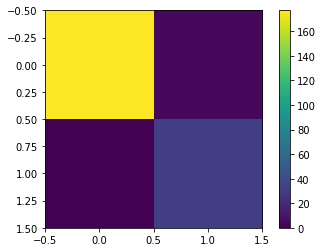

In [27]:

CM = sklearn.metrics.confusion_matrix(target_error_analysis_val, target_error_analysis_val_pred)

plt.imshow(CM)
plt.colorbar()
plt.show()



Confusion matrix, without normalization
[[177   4]
 [  0  33]]
Normalized confusion matrix
[[0.97790055 0.02209945]
 [0.         1.        ]]


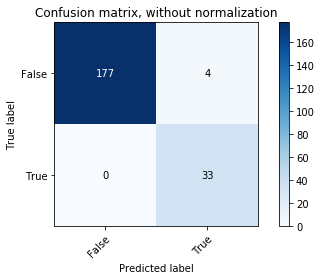

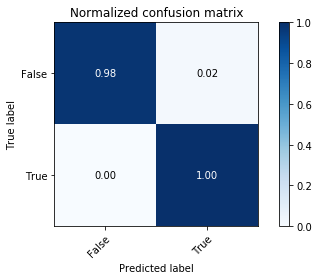

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = ['False', 'True']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(target_error_analysis_val, target_error_analysis_val_pred, classes=np.array(class_names),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(target_error_analysis_val, target_error_analysis_val_pred, classes=np.array(class_names), normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [29]:
# Analyse mislabeled samples
for error_analysis_idx in np.where(target_error_analysis_val != target_error_analysis_val_pred)[0]:
    X_all_idx = np.where(X_error_analysis_val[error_analysis_idx] == X_all)[0][0]
    print(X_all_idx)
    print(model_pipe.predict_proba(X_error_analysis_val[error_analysis_idx].reshape(1,-1))[0][1])
    print(X_all_idx//41+1)
    print(X_all_idx%41+1)
    print(np.sum(X_error_analysis_val[error_analysis_idx]-X_all[X_all_idx]))
    print()



332
0.748897702184519
9
5
0.0

573
0.8130990080421227
14
41
0.0

578
0.7570261030235251
15
5
0.0

602
0.9968463133678293
15
29
0.0



# Train the the production model pipe on all available data


In [30]:
if not RUNNING_ON_HPC:
    # Disable caching before saving model
    model_pipe.memory = None
    rmtree(grid_search_cv_cachedir)


NameError: name 'rmtree' is not defined

In [ ]:
model_pipe.fit(X_all, target_all)

In [31]:
# Save model pipe on disk

if TEST_RUN is False:
    with open(model_pipe_path, 'wb') as f:
      pickle.dump(model_pipe, f, protocol=2) # protocol 2 works with Python 2
      
    print('Saved model to {}'.format(model_pipe_path))
    print('WARNING: this model uses mode {}!!!'.format(fe_mode))
    print('WARNING: this model uses extended_length_semgents={}!!!'.format(extended_length_semgents))

Saved model to /Users/miroslavkovalenko/Documents/project_supporting_material/UGent/Master_Thesis/fase_2/model_pipe.pkl


In [41]:

# Test the saved model
with open(model_pipe_path, 'rb') as file: # Change to use specified path.
    _model_pipe = pickle.load(file)
_model_pipe


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=370, score_func=<function f_classif at 0x10e28ce18>)), ('classifier', LogisticRegression(C=1000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [65]:
# Test the saved model

_model_pipe_path = os.path.join(ml_dir, 'model_pipe_fav9.pkl')
with open(_model_pipe_path, 'rb') as file:
    _model_pipe = pickle.load(file)
_model_pipe


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=270, score_func=<function chi2 at 0x10e28cf28>)), ('classifier', LogisticRegression(C=10000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [66]:
model_pipe = _model_pipe # If you need to analyse it

In [67]:
# X_error_analysis_val[14].shape
_start_time = time.time()
_model_pipe.predict_proba(X_error_analysis_val[14].reshape(1,-1))[0][1]
print('Evaluation of one sample: {:.3f}'.format(time.time() - _start_time))


Evaluation of one sample: 0.005
